# Binary Logistic Regression

**Logistic Regression (Logit Model)**  
- A statistical model used for binary classification problems.
- Predicts the probability of an event occurring based on input features.
- Formula:

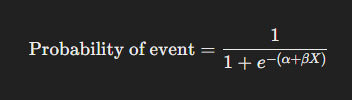

Where:  
𝛼 = Intercept  
𝛽 = Coefficients of independent variables  
𝑋 = Input feature(s)  

**Why an S-shaped curve?**  
Imagine that we are trying to predict the probability of someone buying a home, using income
as the predictor. At very low levels of income, or for small values of the variable X, the
likelihood of buying a home is very small. As income rises, more and more people can afford a
home, and the rate of increase in the probability, per unit of income, also rises. Then, at high
levels of income, most people can afford a home, and since the likelihood must be less than or
equal to one, the curve levels off, so that the rate of increase of probability per unit of income
decreases. The result is an S-shaped, or logistic curve.  
  
Besides, if we try to explain the likelihood of an event, we cannot use a regression model as
that model does not have a theoretical maximum or minimum, that´s another reason for
using a logistic model with the 0-1 limits (same as a probability).

## Import Libraries

In [40]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from statsmodels.api import OLS, add_constant
from faker import Faker
import requests
import matplotlib.pyplot as plt
import seaborn as sns

## Data & Assumptions

1. The independent variables are scale or dichotomous (categorical may or may not be included depending on the platform: if not, they should be converted into dummies)
2. There is an absence of large correlation between the independent variables
3. Requires more sample than Linear Regression → approx. n > 30 * k

In [62]:
# Initialize Faker
fake = Faker()
np.random.seed(42)

# Number of samples
n_samples = 500

# Generate numeric variables
age = np.random.randint(18, 65, n_samples)
salary = np.random.randint(20000, 150000, n_samples)

# Generate binary outcome variable
purchase = (age + salary / 5000 + np.random.randn(n_samples) * 2) > 35
purchase = purchase.astype(int)  # Convert to 0/1

# Generate categorical variables
education_levels = ["High School", "Bachelor's", "Master's", "PhD"]
education = np.random.choice(education_levels, n_samples, p=[0.4, 0.35, 0.2, 0.05])

marital_statuses = ["Single", "Married", "Divorced"]
marital_status = np.random.choice(marital_statuses, n_samples, p=[0.5, 0.4, 0.1])

# Generate boolean variable
owns_car = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])  # 40% own a car

# Create DataFrame
result = pd.DataFrame({
    'age': age,
    'salary': salary,
    'purchased': purchase,
    'education_level': education,
    'marital_status': marital_status,
    'owns_car': owns_car
})

result

,age,salary,purchased,education_level,marital_status,owns_car
0,56,24000,1,Bachelor's,Married,0
1,46,90588,1,High School,Single,1
2,32,121042,1,Master's,Married,1
3,60,113610,1,High School,Single,1
4,25,140420,1,Bachelor's,Single,0
...,...,...,...,...,...,...
495,37,43321,1,PhD,Married,1
496,41,30488,1,Master's,Married,0
497,29,42574,1,PhD,Married,0
498,52,25240,1,Bachelor's,Single,1


All categorical and string variables need to be converted into dummy variables

In [63]:
# Convert categorical variables into dummy variables
result_encoded = pd.get_dummies(result, columns=['education_level', 'marital_status'], drop_first=True)

# Display the first few rows
result_encoded.head()

,age,salary,purchased,owns_car,education_level_High School,education_level_Master's,education_level_PhD,marital_status_Married,marital_status_Single
0,56,24000,1,0,False,False,False,True,False
1,46,90588,1,1,True,False,False,False,True
2,32,121042,1,1,False,True,False,True,False
3,60,113610,1,1,True,False,False,False,True
4,25,140420,1,0,False,False,False,False,True


Check for high correlation and decide which variables to drop

In [65]:
result_encoded.corr()

,age,salary,purchased,owns_car,education_level_High School,education_level_Master's,education_level_PhD,marital_status_Married,marital_status_Single
age,1.000000,-0.012151,0.414183,-0.019445,0.048346,-0.025718,0.017598,0.005675,-0.003559
salary,-0.012151,1.000000,0.303870,0.053334,0.034528,0.008824,-0.026821,-0.042582,0.043877
purchased,0.414183,0.303870,1.000000,-0.077469,0.037905,0.024439,0.007444,0.013093,0.000992
owns_car,-0.019445,0.053334,-0.077469,1.000000,0.030105,-0.094574,0.065369,0.022778,0.008992
education_level_High School,0.048346,0.034528,0.037905,0.030105,1.000000,-0.372137,-0.209918,0.024673,-0.014717
education_level_Master's,-0.025718,0.008824,0.024439,-0.094574,-0.372137,1.000000,-0.117177,-0.019645,0.023732
education_level_PhD,0.017598,-0.026821,0.007444,0.065369,-0.209918,-0.117177,1.000000,0.039430,-0.044745
marital_status_Married,0.005675,-0.042582,0.013093,0.022778,0.024673,-0.019645,0.039430,1.000000,-0.841451
marital_status_Single,-0.003559,0.043877,0.000992,0.008992,-0.014717,0.023732,-0.044745,-0.841451,1.000000


## Model Specification

Estimation. Iterative process to calculate parameters in the model using a maximum–likelihood technique. We derive coefficients that make our observed values most “likely” for the given set of independent variables.
  
**Dependent Variable**
We start by defining the event we are studying
Our event → 𝑌i = 1  

It is necessary to choose one of the categories of the dependent variable. It is not the same to study “churn” than “permanence”  
  
**Independent Variable**
- Either scale variables or
- Categorical ones. These ones should be converted into dummies depending on the platform. There is sometimes one reference category, and the others are compared against it.

### Set X & Y / Split into Train & Test

In [19]:
# Selecting significant figures
X = result[['age', 'salary']]
Y = result['purchased']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

### Stepwise to Identify Significant Variables

It is good practice to use a Stepwise method that allows to select the significant variables. However, this is only a first approach, as this method does not detect collinearity, among other issues.

In [20]:
# Feature Selection Using Stepwise Function
import statsmodels.api as sm

def stepwise_selection(X, y, p_value_threshold=0.05):
    """
    Perform stepwise regression using bidirectional elimination.

    Parameters:
    X (pd.DataFrame): Feature matrix
    y (pd.Series): Target variable
    p_value_threshold (float): Maximum p-value to keep a variable in the model

    Returns:
    list: Final list of selected features
    """
    X = X.copy()
    selected_features = list(X.columns)

    while True:
        # Fit model with selected features
        X_with_const = sm.add_constant(X[selected_features])
        model = sm.OLS(y, X_with_const).fit()

        # Get p-values
        p_values = model.pvalues.iloc[1:]  # Exclude constant

        # Identify the feature with the highest p-value
        worst_feature = p_values.idxmax()
        worst_p_value = p_values.max()

        # If the highest p-value is greater than the threshold, remove the feature
        if worst_p_value > p_value_threshold:
            selected_features.remove(worst_feature)
            print(f"Removing {worst_feature} (p-value: {worst_p_value:.4f})")
        else:
            break  # Stop when all p-values are below the threshold

    return selected_features

# Example Usage with an Existing Dataset
selected_features = stepwise_selection(X, Y)
print(f"Final selected features: {selected_features}")

Final selected features: ['age', 'salary']


### OLS to Identify Significant Variables

In [25]:
# Feature Selection using OLS
x_constant = add_constant(X)
ols_model = OLS(Y, x_constant).fit()

significant_features = ols_model.pvalues[ols_model.pvalues < 0.05].index.tolist()
if 'const' in significant_features:
    significant_features.remove('const')

print(f'Significant Features:\n{significant_features}')

Significant Features:
['age', 'salary']


In [26]:
x_selected = X[significant_features] # or x_selected = X[selected_features] (for stepwise)

X_train, X_test, Y_train, Y_test = train_test_split(x_selected, Y, test_size = 0.2, random_state = 42)

## Feature Scaling

In [27]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Model Selection & Prediction

In [28]:
# Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_scaled, Y_train)

LogisticRegression()

In [33]:
# Make Predictions
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1] # Getting probabilities for class 1

## Model Performance

In [34]:
# Evaluate Model Performance
accuracy = accuracy_score(Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_pred_prob)
print(f'Accuracy: {accuracy:.2f}')
print(f'ROC-AUC Score: {roc_auc:.2f}')
print('\nClassification Report:')
print(classification_report(Y_test, y_pred))

Accuracy: 0.98
ROC-AUC Score: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.98      0.99        95

    accuracy                           0.98       100
   macro avg       0.86      0.99      0.91       100
weighted avg       0.99      0.98      0.98       100



## Model Selection & Analysis

In addition, Logit Analysis is usually defined in terms of Odds for the event to occur:  
𝑂𝑑𝑑𝑠(𝑒𝑣𝑒𝑛𝑡) = 𝑃𝑟𝑜𝑏(𝑒𝑣𝑒𝑛𝑡) / 𝑃𝑟𝑜𝑏 (𝑛𝑜 𝑒𝑣𝑒𝑛𝑡) = 𝑒𝛼+𝛽1𝑋1i+𝛽2𝑋2i  
  
And between several events, through the Odds ratio:  
𝑂𝑑𝑑𝑠 𝑟𝑎𝑡𝑖𝑜 = 𝑂𝑑𝑑𝑠(𝑒𝑣𝑒𝑛𝑡 1) / 𝑂𝑑𝑑𝑠(𝑒𝑣𝑒𝑛𝑡 2)  
  
If we want to define it in terms of probability:  
𝑃𝑟𝑜𝑏(𝑒𝑣𝑒𝑛𝑡) = 𝑂𝑑𝑑𝑠(𝑒𝑣𝑒𝑛𝑡) / 1 + 𝑂𝑑𝑑𝑠 (𝑒𝑣𝑒𝑛𝑡)

### Summary
**Pseudo R-squared: 0.886**  
- This is like 𝑅2in linear regression but adapted for logistic regression.
- A value close to 1 suggests a strong fit.  
  
**AIC (30.94) and BIC (42.91)**  
- Lower values indicate better model fit.
- AIC/BIC are used to compare models (lower is better).  
  
**Log-Likelihood (-12.469)**  
- Measures how well the model predicts the data.
- The closer to 0, the better.  

**LL-Null (-109.05)**  
- Log-likelihood for a baseline model (without predictors).
- If our LL (-12.469) is much better than LL-Null (-109.05), the model is useful.  

**LLR p-value (1.1385e-42)**  
- Measures if the model is statistically significant overall.
- A very small p-value (< 0.05) confirms that the model is meaningful.

In [ ]:
# Logistic Regression Coefficients, Confidence Intervals, and Odds Ratios
X_train = sm.add_constant(X_train)
logit_model = sm.Logit(Y_train, X_train)
result = logit_model.fit_regularized()
print(result.summary2())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03117345956135736
            Iterations: 36
            Function evaluations: 50
            Gradient evaluations: 36
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: purchased        Pseudo R-squared: 0.886     
Date:               2025-02-09 14:24 AIC:              30.9388   
No. Observations:   400              BIC:              42.9132   
Df Model:           2                Log-Likelihood:   -12.469   
Df Residuals:       397              LL-Null:          -109.05   
Converged:          1.0000           LLR p-value:      1.1385e-42
No. Iterations:     36.0000          Scale:            1.0000    
------------------------------------------------------------------
            Coef.    Std.Err.     z     P>|z|    [0.025    0.975] 
------------------------------------------------------------------
const      -37.6306 

c:\Users\SABIO\Documents\GitHub\Personal-Projects\myenv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

c:\Users\SABIO\Documents\GitHub\Personal-Projects\myenv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log



### Odds Ratio & Confidence Intervals

These are **log-odds**, not direct probabilities.

| Variable  | Interpretation |
|-----------|---------------|
| **Intercept (-37.63)** | Baseline log-odds when all predictors = 0. A large negative value suggests that, without predictors, purchase is very unlikely. |
| **Age (1.1480)** | A **1-year increase in age increases log-odds by 1.15** (which is quite large). |
| **Salary (0.0002)** | A **1-unit increase in salary increases log-odds by 0.0002** (very small, likely due to large salary values). |

p-values
- **All values are < 0.05**, so both **Age and Salary** are statistically significant.

95% Confidence Interval ([0.025, 0.975])
- **Age**: \([0.48, 1.81]\) → Since **both values are positive**, age **significantly increases the likelihood of purchase**.
- **Salary**: \([0.0001, 0.0003]\) → Both values are positive, meaning salary also has a significant effect.

Odds Ratios (Exp(B)) and Confidence Intervals
| Variable | Lower Bound | Upper Bound | Odds Ratio |
|----------|------------|------------|------------|
| **Age** | 1.62 | 6.15 | 3.15 |
| **Salary** | 1.00008 | 1.0003 | 1.0002 |

- **Age (OR = 3.15)**: **Each additional year makes purchase 3.15× more likely**.
- **Salary (OR = 1.0002)**: **A small but statistically significant effect**.

Final Interpretation
- **Model Fit**:
  - **Pseudo R² (0.886)** suggests a strong model.
  - **LLR p-value** is very low, confirming the model is statistically meaningful.

- **Key Predictors**:
  - **Age** has a **strong positive effect** on purchase probability.
  - **Salary** has a **small but statistically significant effect**.

In [55]:
# Compute Exp(B) and Confidence Intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Lower', 'Upper', 'Odds Ratio']
print("\nExp(B) & Confidence Intervals:")
print(np.exp(conf))


Exp(B) & Confidence Intervals:
               Lower         Upper    Odds Ratio
const   1.762549e-26  1.170474e-07  4.542046e-17
age     1.616515e+00  6.145180e+00  3.151789e+00
salary  1.000078e+00  1.000295e+00  1.000187e+00


## Model Performance

Validation: Check model goodness  
1. Individual: Check significance of variables (Wald test)  
2. As a whole: Several measures to look at (in bold the most relevant):  
    - Check if your analysis improves the current classification  
    - Check different metrics: precision, sensitivity, specificity, AUC, etc.  
    - Check for atypical points that might influence the outcomes  
    - ROC curve (explained at the end of this chapter)  

### Confusion Matrix with Cutoff

A cutoff should always be set up. A machine learning model usually outputs a probability of belonging to one of the two groups, and the actual predicted value depends on which threshold we decide to use on this probability (i.e. at which probability do we decide to classify our customer as a high value one)

In [ ]:
# Confusion Matrix
cutoff = 0.5
train_preds_binary = (y_pred > cutoff).astype(int)  # Convert to binary labels (0 o 1)

cm = confusion_matrix(Y_test, train_preds_binary)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

fig_cm = px.imshow(cm, text_auto=True, color_continuous_scale='Blues')
fig_cm.update_layout(title='Confusion Matrix', xaxis_title='Predicted', yaxis_title='Actual')
fig_cm.show()

- **True Positive (TP)** → The model correctly predicted a **positive** class.
- **False Positive (FP)** → The model **incorrectly predicted positive**, but it was actually **negative** (Type I Error).
- **True Negative (TN)** → The model correctly predicted a **negative** class.
- **False Negative (FN)** → The model **incorrectly predicted negative**, but it was actually **positive** (Type II Error).

---

In [56]:
# Step 11: Compute Confusion Matrix Ratios
TN, FP, FN, TP = cm.ravel()

# Calculate Metrics
sensitivity = TP / (TP + FN)  # True Positive Rate / Recall
specificity = TN / (TN + FP)  # True Negative Rate
precision = TP / (TP + FP)  # Positive Predictive Value
negative_predictive_value = TN / (TN + FN)  # Negative Predictive Value
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)  # F1 Score

# Print Metrics
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Negative Predictive Value: {negative_predictive_value:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Sensitivity (Recall): 0.98
Specificity: 1.00
Precision: 1.00
Negative Predictive Value: 0.71
F1 Score: 0.99


**Key Performance Metrics from the Confusion Matrix**

**1️⃣ Sensitivity (Recall or True Positive Rate)**
\[
{Sensitivity} = {TP} / {TP + FN}
\]
- Measures **how many actual positives were correctly identified**.
- High recall means the model **does not miss many positives**.
- **Important for medical tests** (e.g., detecting cancer, where missing a positive case is dangerous).

High Sensitivity** → Few false negatives.

---

**2️⃣ Specificity (True Negative Rate)**
\[
{Specificity} = {TN} / {TN + FP}
\]
- Measures **how many actual negatives were correctly identified**.
- High specificity means the model **avoids false positives**.
- **Important for spam detection** (high specificity reduces false spam alerts).

High Specificity** → Few false positives.

---

**3️⃣ Precision (Positive Predictive Value)**
\[
{Precision} = {TP} / {TP + FP}
\]
- Measures **how many predicted positives were actually correct**.
- High precision means **less false alarms**.
- **Important for fraud detection** (high precision avoids accusing innocent users).

High Precision** → Fewer false positives.

---

**4️⃣ Negative Predictive Value (NPV)**
\[
{NPV} = {TN} / {TN + FN}
\]
- Measures **how many predicted negatives were actually correct**.
- High NPV means the model **is reliable in predicting negatives**.
- **Important for ruling out diseases in medical tests**.

High NPV** → Fewer false negatives.

---

**5️⃣ F1 Score**
\[
F1 = 2 * ({Precision} * {Recall}) / ({Precision} + {Recall})
\]
- Harmonic mean of **Precision and Recall**.
- Best for **imbalanced datasets**.
- **Balances false positives and false negatives**.

High F1 Score** → Good balance between precision and recall.

---

**4. Summary**
- **Sensitivity (Recall)** → Catch **all positives** (important in medical tests).
- **Specificity** → Catch **all negatives** (important in spam detection).
- **Precision** → Ensure **predicted positives are correct** (important in fraud detection).
- **Negative Predictive Value (NPV)** → Ensure **predicted negatives are correct**.
- **F1 Score** → Balance **false positives and false negatives**.

### ROC & AUC

#### ROC  
ROC Curve and AUC Interpretation

**What is the ROC Curve?**
The **Receiver Operating Characteristic (ROC) curve** is a graphical representation that illustrates the performance of a classification model across different decision thresholds.

- It plots **True Positive Rate (TPR) vs. False Positive Rate (FPR)**.
- The **higher** the TPR and the **lower** the FPR, the better the model.

**How to Interpret the ROC Curve**
- A **perfect classifier** will have a curve that **rises sharply towards the top left corner**.
- A **random model** will have a **diagonal line** (FPR = TPR), meaning it is no better than random guessing.
- The closer the curve is to the top-left corner, the **better the classifier**.

---

Depending on the economical valuation of both cases, we might want to prioritize one or other. How? We can achieve this by modifying the classification cutoff so that we force our model to fail more on one or other error.
  
This is achieved by using the ROC curve (Receiver Operating Characteristic), which simulates all possible values for False Positive and True Positive rates for every cutoff.

In [38]:
fpr, tpr, _ = roc_curve(Y_test, y_pred_prob)
fig = go.Figure()
fig.add_trace(go.Scatter(x = fpr, y = tpr, mode='lines', name='ROC Curve'))
fig.add_trace(go.Scatter(x = [0, 1], y = [0, 1], mode = 'lines', line = dict(dash = 'dash'), name = 'Random Model'))
fig.update_layout(title = 'ROC Curve', xaxis_title = 'False Positive Rate', yaxis_title = 'True Positive Rate')
fig.show()

- Y axis is Sensitivity: True positive rate (when the model is correct detecting good risk, something we pursue)
- X axis is 1-Specificity: False positive rate (when the model predicts our event: good risk and the reality -historical data- is bad loss). Note that X axis is the inverse of Specificity, which is the True Negative rate
- The diagonal: if test and state variables are uncorrelated.  
  
One would normally be interested in areas of the plot in which the curve rises rapidly, indicating a **large increase in true positives with little change in false positives.**

#### AUC

**What is AUC (Area Under the Curve)?**
The **AUC (Area Under the Curve)** is a single metric that summarizes the performance of the classifier.
- AUC represents the probability that the model ranks a randomly chosen **positive instance** higher than a randomly chosen **negative instance**.

**How to Interpret AUC**
| AUC Value | Model Performance |
|-----------|------------------|
| **0.90 - 1.00** | Excellent |
| **0.80 - 0.90** | Very Good |
| **0.70 - 0.80** | Fair |
| **0.60 - 0.70** | Poor |
| **0.50 - 0.60** | Very Poor (almost random) |

- **AUC = 1.0** → **Perfect classifier** (all positives ranked higher than negatives).
- **AUC = 0.5** → **Random classifier** (model is no better than flipping a coin).
- **AUC < 0.5** → **Worst than random guessing** (something is wrong with the model).

---

**Example Interpretation**
If a model has **AUC = 0.88**, it means:
- There is an **88% chance** that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance.
- The model performs well but is not perfect.

---

**Final Takeaways**
- **ROC Curve helps visualize model performance at different thresholds**.
- **AUC gives a single score summarizing how well the classifier separates positive and negative classes**.
- **The higher the AUC, the better the model at distinguishing between classes**.

### Optimizing the Model Based on (Cost & Benefit)

**The question to ask ourselves is whether this is worth or not**  
  
It is only about simulating different scenarios and calculating benefits and costs for each.
For Example:
— Negatives incorrectly predicted as Positives cost 50€ each
— Positives correctly predicted produce 45€ benefit each.  
  
You would need to calculate at which cutoff point generates the highest benefit

## Model Utilization

Utilization. Prediction / Simulation / Structural Analysis  
  
We can use the estimates (Beta parameters) to build an equation and obtain the forecasts. For that, we consider the Beta column (which later will have to be transformed into the logit form).

Plug the values into the formula - transform that obtained forecast into logistic scale so that we get the probability estimated by our model.

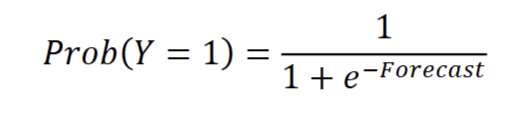

In [ ]:
model.predict("""Insert the dictionary of values to go into the model""")